# Visualizing Flight Test Data Interactively With Open Source Tools
---
## Society of Flight Test Engineers 49th Annual International Symposium
### 10 October 2018, Savannah GA
### Luke Starnes (GTRI)

# Agenda
* OSS Value Proposition
* ADS-B Background
* Tooling Overview
* Examples

# OSS Value Proposition


* Proprietary data analysis tools are expensive and create “vendor lock”
* Walled Garden
 ![](images/walled_garden.jpg)

* open source tools are a superior choice for today’s flight test analysis problems
* open interfaces
* widespread compatibility (community of interoperable tools)
* seamless migration between tools (no “vendor lock”)
* flexibility and agility

# Open Flight Data as Lens for Talking OSS Tooling

<table><tr><td><img src='images/adsb.png'></td><td><img src='images/lens.png'></td><td><img src='images/osi_logo.png'></td></tr></table>

# ADS-B Background
* Automatic Dependent Surveillance-Broadcast
* Airfract system for broadcasting identification and position data
* Facilitated by uibiquity of GPS
* Driven by cost of maintaining ATC radars
* ADSB mandated in US starting Jan 1, 2020
 * required for aircraft operating about 10k', around airports, or off Gulf of Mexico
* European mandate starts Jan 1, 2019

* ADSB is Line of Sight - requires network of ground stations to recieve reports (min ~100NM)
![](images/adsb_ground_stations.png)

* Transmissions are unencrypted
* Thus a preponderance of...

![](images/prostick.jpg)

![](images/planefinder.png)

* ADSB-B Exchange (www.adsbexchange.com) provides public access to their worldwide dataset (begins June 9, 2016)
![](images/adsbexchange_logo_full.png)
* Data made available as JSON
* Each day is a single zip file with 1,440 JSON files (1 file per minute)

# OSS Tool Stack

* HDF5
* Pandas
* Luigi
* Jupyter
* Bokeh
* Datashader

In [1]:
import bokeh
from bokeh.plotting import figure
import bokeh.plotting as plotting
from bokeh.io import output_file, show, save
from bokeh.util.browser import view
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource,CategoricalColorMapper,
    PanTool, WheelZoomTool, BoxZoomTool, ResetTool, GMapOptions, HoverTool,
ZoomInTool,ZoomOutTool)
from bokeh.palettes import Spectral6, d3
from bokeh.transform import linear_cmap
import yaml
import pandas as pd
from IPython.core.display import display, HTML
from IPython.display import Image
# from utils import toWebMercator
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
plotting.output_notebook()

Loading BokehJS ...

In [4]:
# Load Google API credentials
# You will need a file called *credentials.yaml* in your working directory. This file needs to be formatted as follows:
# * api_key: 'ABCD999....'
with open('credentials.yaml') as f:
    credentials = yaml.load(f)
API_KEY = credentials['api_key']

In [5]:
def ticks_to_datetime(ticks, rtn_type='datetime'):
    if rtn_type == 'datetime':
        return dt.datetime.fromtimestamp(ticks / 1000)
    elif rtn_type == 'time_string':
        return dt.datetime.fromtimestamp(ticks / 1000).strftime('%H:%M:%S.%f')
    elif rtn_type == 'time_string_short':
        return dt.datetime.fromtimestamp(ticks / 1000).strftime('%H:%M')
    elif rtn_type == 'datetime_string':
        return dt.datetime.fromtimestamp(ticks / 1000).strftime('%m-%d-%Y %H:%M:%S.%f')
def datetime_to_ticks(dt_):
    return dt.datetime.timestamp(dt_)*1000
now=dt.datetime.now()
assert ticks_to_datetime(datetime_to_ticks(now), 'datetime') == now

In [9]:
# h5_dir = '/users/lukestarnes/Documents/adsb'
h5_dir = r'C:\adsb'
h5_files = [os.path.join(h5_dir, f) for f in os.listdir(h5_dir)]
with pd.HDFStore(h5_files[1]) as store:
    columns_to_keep = ['Lat','Long','Alt','PosTime','To','From','Icao','Id','Mdl',
                   'Spd', 'Trak', 'TTrk', 'Man', 'Op']
    condition = '(Icao == "896194") | (Icao == "3445D4")'
    df_flt1 = store.select('data', where=condition,
                           columns=columns_to_keep).dropna(subset=('Lat','Long'))

In [10]:
df_flt1['Time'] = df_flt1.PosTime.apply(ticks_to_datetime)
df_flt1['TimeString'] = df_flt1.PosTime.apply(lambda x: ticks_to_datetime(x,"time_string_short")+"Z")

In [11]:
legs = df_flt1[['From','To']].drop_duplicates().dropna().set_index('From').to_dict()['To']
for i, (f, t) in enumerate(legs.items()):
    t = [t]
    f = [f]
    criteria = "From == @f & To == @t"
    df_flt1.loc[df_flt1.eval(criteria), 'Leg'] = i + 1

In [13]:
airport_codes_url='http://ourairports.com/data/airports.csv'
airport_codes = pd.read_csv(airport_codes_url,index_col=0,parse_dates=[0])

In [14]:
legs = df_flt1[['From','To']].drop_duplicates().dropna().set_index('From').to_dict()['To']
for i, (f, t) in enumerate(legs.items()):
    print(f'Leg {i+1}:')
    df_flt_leg = df_flt1[(df_flt1['From'] == f) & (df_flt1['To'] == t)]
    from_airport = airport_codes[airport_codes['ident'] == f].name.values[0]
    to_airport = airport_codes[airport_codes['ident'] == t].name.values[0]
    departure_time = ticks_to_datetime(df_flt_leg.PosTime.min(),'time_string_short')
    arrival_time = ticks_to_datetime(df_flt_leg.PosTime.max(),'time_string_short')
    print(f'Departed {from_airport} at {departure_time}Z and arrived at {to_airport} at {arrival_time}Z')

Leg 1:
Departed Adolfo Suárez Madrid–Barajas Airport at 14:13Z and arrived at Brussels Airport at 16:00Z
Leg 2:
Departed Dubai International Airport at 07:15Z and arrived at London Heathrow Airport at 10:55Z
Leg 3:
Departed London Heathrow Airport at 15:11Z and arrived at Dubai International Airport at 18:12Z


# WITH GMAPS

In [33]:
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import CARTODBPOSITRON
from datashader.utils import lnglat_to_meters as webm

In [15]:
x_range = Range1d(-160, 160)
y_range = Range1d(-80, 80)

map_options = GMapOptions(lat=df_flt1.Lat.mean(), #lat of center
                          lng=df_flt1.Long.mean(), #long of center
                          map_type="roadmap",
                          zoom=4)

plot = GMapPlot(
    x_range=x_range,
    y_range=y_range,
    map_options=map_options,
    api_key=API_KEY,
)
icoas = ', '.join(list(df_flt1.Icao.value_counts().index))
plot.title.text = f"Flights on ICOAs {icoas}"
mapper = linear_cmap(field_name='Leg', palette=Spectral6 ,low=df_flt1.Leg.min() ,high=df_flt1.Leg.max())
circle = Circle(x="Long", y="Lat", size=3, line_color=None, fill_color=mapper, fill_alpha=0.9)
plot.add_glyph(ColumnDataSource(df_flt1), circle)

tooltips = [
    ("ICAO", "@Icao"),
    ("To-From", "@To-@From"),
    ("Lat, Long", "@Lat, @Long"),
    ("Alt", "@Alt'"),
    ('Gnd Speed', '@Spd knts'),
    ('Aircraft', '@Mdl'),
    ('Airline', '@Op'),
    ('Heading','@Trak deg'),
    ('Time', """@TimeString
    <style>
        .bk-tooltip>div:not(:first-child) {display:none;}
        </style>""")]
#https://stackoverflow.com/a/51249293/6334587


plot.add_tools(PanTool(), WheelZoomTool(), BoxZoomTool(),ResetTool(),
               ZoomInTool(),ZoomOutTool(),HoverTool(tooltips=tooltips))

show(plot)

# WITH TILES

In [34]:
w = webm(df_flt1.Long, df_flt1.Lat)
df_flt1.loc[:,'x'] = w[0]
df_flt1.loc[:,'y'] = w[1]

In [39]:
WesternEuro = ((-1000000, 4000000), (4000000, 9000000))
x_range, y_range = WesternEuro
p = figure(x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator")
circle = Circle(x="x", y="y", size=3, line_color=None, fill_color=mapper, fill_alpha=0.9)
p.add_glyph(ColumnDataSource(df_flt1), circle)
p.add_tile(CARTODBPOSITRON)
p.add_tools(PanTool(), WheelZoomTool(), BoxZoomTool(),ResetTool(),
               ZoomInTool(),ZoomOutTool(),HoverTool(tooltips=tooltips))
show(p)

# Fun with Bokeh and DS

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
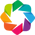

In [41]:
import os
import pandas as pd
from functools import partial
import fastparquet
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import Greys9, Hot, inferno, Sets1to3, colormap_select as cm
from colorcet import fire
from matplotlib.cm import hot
from datashader.colors import viridis
import numpy as np
# from utils import mega_color
import dask.dataframe as dd
from IPython.display import Image, display
# from PIL import Image as PI
import holoviews.operation.datashader as hd

# import numpy as np
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
# from holoviews.operation import decimate
hv.extension('bokeh','matplotlib')
# decimate.max_samples=1000
# dynspread.max_px=20
# dynspread.threshold=0.5
from bokeh.models import WMTSTileSource
import geoviews as gv
import dask

# from dask.cache import Cache
# cache = Cache(2e9)  # Leverage two gigabytes of memory
# cache.register()    # Turn cache on globally
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [43]:
print(f'Pandas version: {pd.__version__}')
print(f'Bokeh version: {bokeh.__version__}')
print(f'Datashader version: {ds.__version__}')
print(f'holoviews version: {hv.__version__}')
print(f'dask version: {dask.__version__}')
print(f'geoviews version: {gv.__version__}')

Pandas version: 0.23.4
Bokeh version: 0.13.0
Datashader version: 0.6.8
holoviews version: 1.10.7
dask version: 0.17.4
geoviews version: 1.4.3


In [3]:
def create_image(x_range, y_range, name, w=plot_width, h=plot_height,
                 agg_method=None, cmap=["lightblue", "darkblue"], shade_agg_func=None,
                 color_key=Sets1to3, how='eq_hist', background="black", dynspread=False, local=False):
    r = ratio((x_range, y_range))
    w = int(plot_height*r)
    cvs = ds.Canvas(w, h, x_range, y_range)
    agg = cvs.points(ddf, 'x', 'y', agg=agg_method)
    if shade_agg_func is None:
        img = tf.shade(agg, cmap = cmap, color_key=color_key)
    else:
        img = tf.shade(shade_agg_func(agg), cmap = cmap)
    if dynspread:
        img = tf.dynspread(img, threshold=0.5, max_px=4)
    export_image(img, name, fmt=".png", background=background)
    if local:
        display_image(name + '.png')

In [4]:
m_to_mi = 0.000621371
def enlarge_box(pts, val):
    val = int(val / m_to_mi)
    return ((pts[0][0] - val, pts[0][1] + val),
            (pts[1][0] - val, pts[1][1] + val))
def pts_to_miles(pts):
    return ((pts[0][0] * m_to_mi, pts[0][1] * m_to_mi),
            (pts[1][0] * m_to_mi, pts[1][1] * m_to_mi))


In [9]:
def display_image(img):
    im = PI.open(img)
    im.thumbnail((600,600))
    display(im)

In [46]:
def spread(pts):
    return ((pts[0][1] - pts[0][0]),
            (pts[1][1] - pts[1][0]))
def ratio(pts):
    s = spread(pts)
    x, y = s
    return x / y

In [50]:
parq_file = r'L:\Starnes_Luke\dev\2018.parq'
ddf = dd.read_parquet(parq_file)

[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed |  2min 18.0s


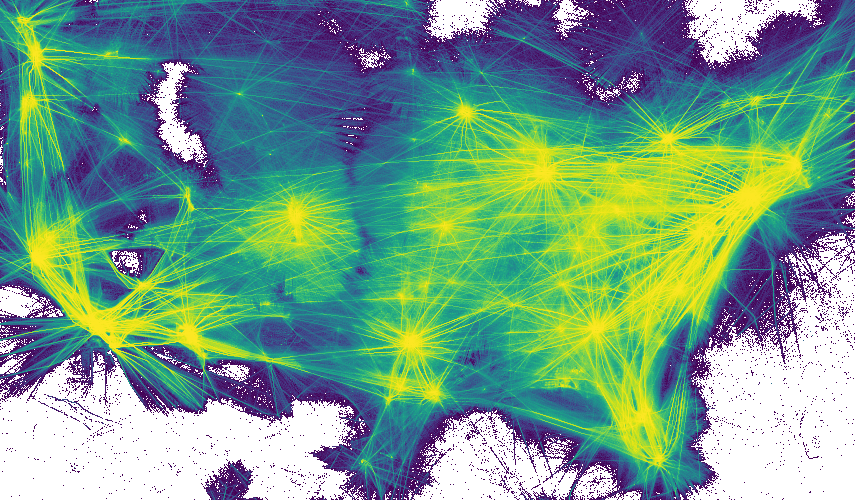

In [52]:
plot_height=500
USA_CONUS = ((-13884029, -7453304), (2698291, 6455972))
x_range, y_range = USA_CONUS
cmap=viridis
color_key=Sets1to3
r = ratio((x_range, y_range))
w = int(plot_height*r)
h=plot_height
cvs = ds.Canvas(w, h, x_range, y_range)
agg = cvs.points(ddf, 'x', 'y')
tf.set_background(tf.shade(agg, cmap = cmap, color_key=color_key), 'black')

In [56]:
plot_height=500
NewYorkCity = (( -8280656, -8175066), (4940514, 4998954))
x_range, y_range = NewYorkCity
cmap=viridis
color_key=Sets1to3
r = ratio((x_range, y_range))
w = int(plot_height*r)
h=plot_height
cvs = ds.Canvas(w, h, x_range, y_range)
agg = cvs.points(ddf, 'x', 'y')
tf.set_background(tf.shade(agg, cmap = cmap, color_key=color_key), 'black')

In [4]:
parq_file = r'L:\Starnes_Luke\dev\2018.parq'
ddf = dd.read_parquet(parq_file)
# dataset = gv.Dataset(ddf,kdims=['x','y'])
dataset = hv.Dataset(ddf,kdims=['x','y'])
points = hv.Points(dataset)

USA_CONUS = ((-13884029, -7453304), (2698291, 6455972))
x_range, y_range = USA_CONUS
r = ratio((x_range, y_range))
h = 1000
w = int(h*r)

# shade_defaults = dict(x_range=x_range, y_range=y_range)#, 
# #                       x_sampling=10, y_sampling=10, 
# #                       width=w, height=h)
# shaded = datashade(hv.Points(dataset),  cmap=viridis, 
#                    x_range=x_range, y_range=y_range).options(width=w, height=h)
shaded = hd.datashade(points, cmap=viridis).redim.range(x=x_range, y=y_range).opts(plot=dict(height=700,width=700))

In [8]:
tiles_url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
tiles = gv.WMTS(WMTSTileSource(url=tiles_url))

In [ ]:
tiles * shaded

[########################################] | 100% Completed |  3min  0.7s
[########################################] | 100% Completed |  1min 10.2s
[########################################] | 100% Completed |  2min 29.4s
[########################################] | 100% Completed | 41.8s
[                                        ] | 0% Completed |  0.1s

C:\Users\ss276\AppData\Local\Continuum\miniconda3\envs\py3.6_adsb\lib\site-packages\holoviews\operation\datashader.py:178: RuntimeWarning: invalid value encountered in double_scalars
  np.linspace(ystart+yunit/2., yend-yunit/2., height))


[########################################] | 100% Completed |  2min 31.9s
[########################################] | 100% Completed | 15.4s
[#                                       ] | 3% Completed | 29.3s

In [ ]:
# shaded.options(width=1200, height=1200)